Objective: Identify companies (accounts) that have high potential return on investment (ROI) based on their sales activity data and other characteristics.


Please create comma separated values (csv) data files for Salesforce.com CRM objects 'Account', 'Opportunity', 'Opportunity Stage', 'Opportunity Team Member', 'Contact', 'Opportunity Activity' (Task), and 'Task Relation'. Please generate at least 1000 records per object. Note: the Salesforce 'Account' object should also include custom fields (ending in a suffix, '__c'), such as OwnerIntentToSell__c, TotalFundingtoDate__c, and HQLocation__c.



# Libraries Import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score

# Data acquisition

In [32]:
account_df = pd.read_csv('data/account.csv', sep=',')
opportunity_df = pd.read_csv('data/opportunity.csv', sep=',')
opportunity_stage_df = pd.read_csv('data/Opportunity_Stage.csv', sep=',')
opportunity_team_member_df = pd.read_csv('data/Opportunity_Team_Member.csv', sep=',')
contact_df = pd.read_csv('data/Contact.csv', sep=',')
opportunity_activity_task_df = pd.read_csv('data/Task_Data.csv', sep=',')
task_relation_df = pd.read_csv('data/Task_Relation.csv', sep=',')

# Data Understanding

### Understanding Accounts

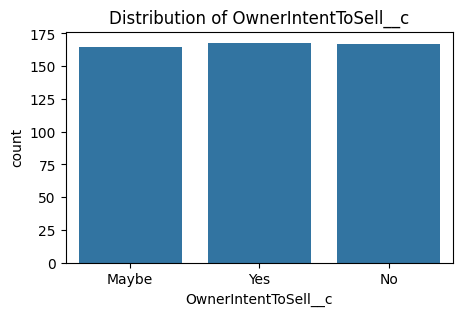

In [3]:
### 1 - Try to understanding 

plt.figure(figsize=(5, 3))
sns.countplot(x='OwnerIntentToSell__c', data=account_df)
plt.title('Distribution of OwnerIntentToSell__c')
plt.show()


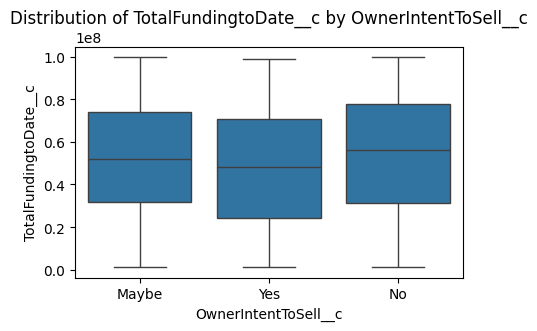

In [4]:
# Boxplot of TotalFundingtoDate__c by OwnerIntentToSell__c
plt.figure(figsize=(5, 3))
sns.boxplot(x='OwnerIntentToSell__c', y='TotalFundingtoDate__c', data=account_df)
plt.title('Distribution of TotalFundingtoDate__c by OwnerIntentToSell__c')
plt.show()


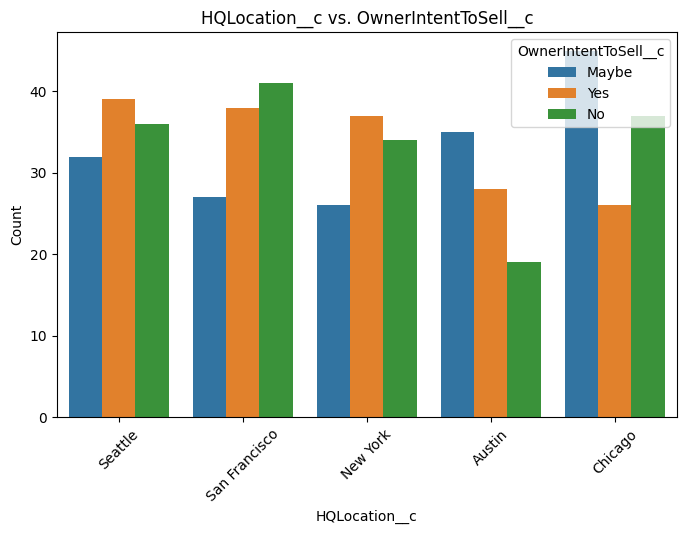

In [31]:
yes_counts = account_df[account_df['OwnerIntentToSell__c'] == 'Yes']['HQLocation__c'].value_counts()
ordered_locations = yes_counts.index
account_df['HQLocation__c'] = pd.Categorical(account_df['HQLocation__c'], categories=ordered_locations, ordered=True)

# Step 4: Visualize the relationship between HQLocation__c and OwnerIntentToSell__c, ordered by "YES" count
plt.figure(figsize=(8, 5))
sns.countplot(x='HQLocation__c', hue='OwnerIntentToSell__c', data=account_df, order=ordered_locations)
plt.title('HQLocation__c vs. OwnerIntentToSell__c')
plt.xlabel('HQLocation__c')
plt.ylabel('Count')
plt.legend(title='OwnerIntentToSell__c')
plt.xticks(rotation=45)
plt.show()


### Understanding Opportunities

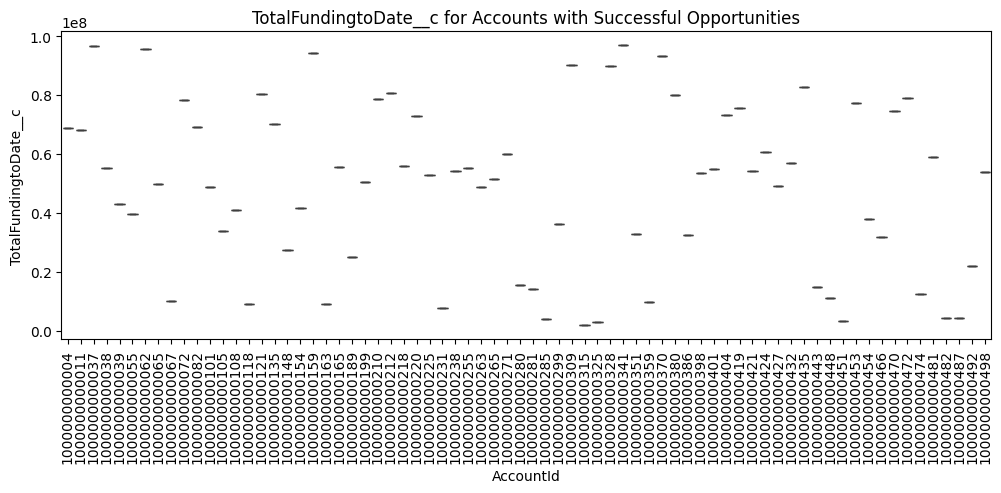

In [6]:
# Question 1: Are the companies that are most successful in opportunities the same ones that have the highest TotalFundingtoDate__c value?
# Filter only won opportunities
won_opportunities = opportunity_df[opportunity_df['StageName'] == 'Closed Won']
won_accounts = pd.merge(won_opportunities, account_df, on='AccountId')

# Boxplot of TotalFundingtoDate__c by AccountId
plt.figure(figsize=(12, 4))
sns.boxplot(x='AccountId', y='TotalFundingtoDate__c', data=won_accounts)
plt.title('TotalFundingtoDate__c for Accounts with Successful Opportunities')
plt.xticks(rotation=90)
plt.show()

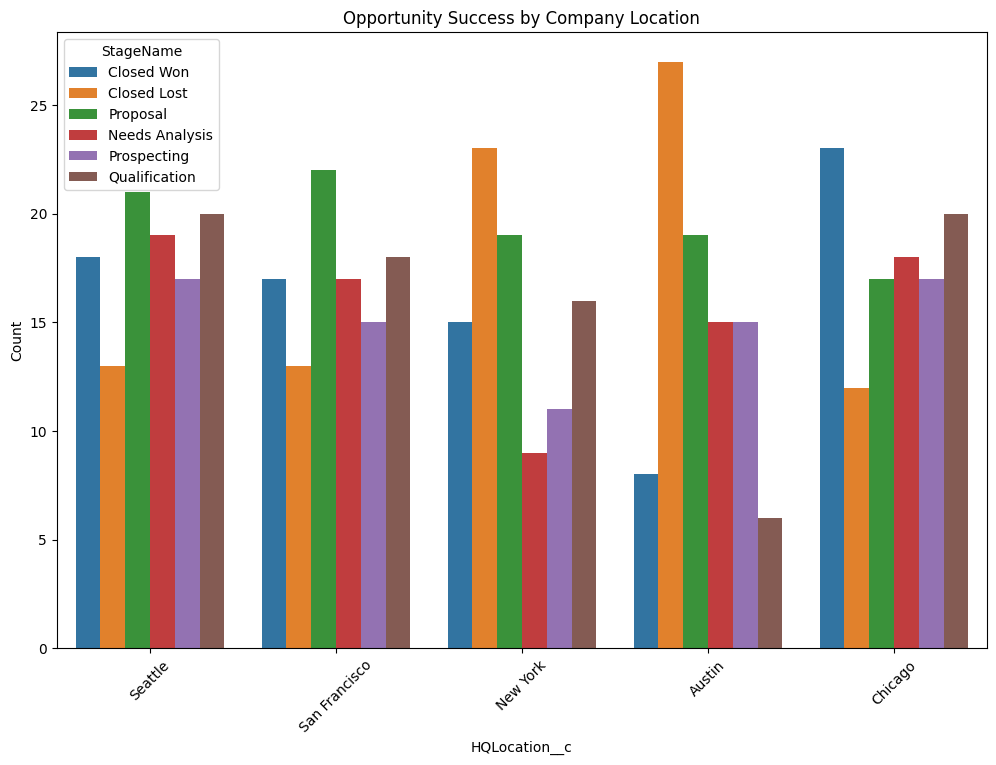

In [7]:
# Question 2: Is the location of companies related to the success of the opportunity they may have?
# Count of won opportunities by location
plt.figure(figsize=(12, 8))
sns.countplot(x='HQLocation__c', hue='StageName', data=pd.merge(opportunity_df, account_df, on='AccountId'))
plt.title('Opportunity Success by Company Location')
plt.xlabel('HQLocation__c')
plt.ylabel('Count')
plt.legend(title='StageName')
plt.xticks(rotation=45)
plt.show()

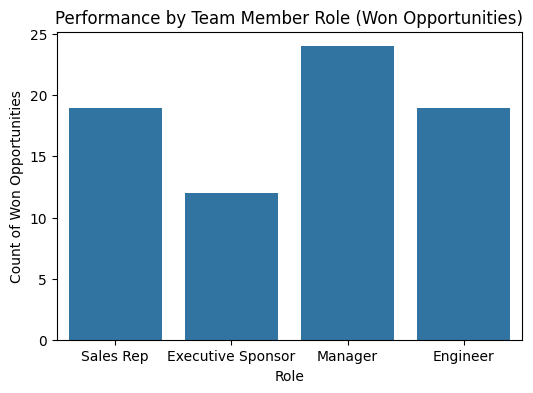

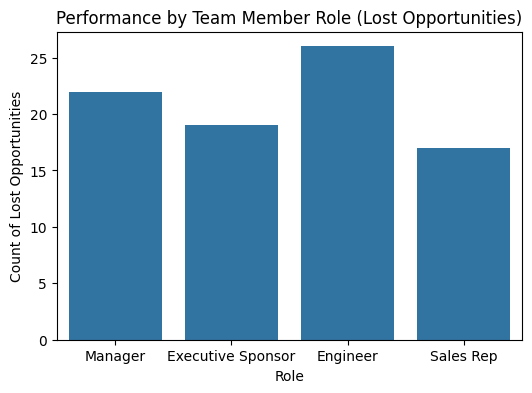

In [8]:

won_opportunities = opportunity_df[opportunity_df['StageName'] == 'Closed Won']
team_performance_won = pd.merge(opportunity_team_member_df, won_opportunities[['OpportunityId']], on='OpportunityId')


plt.figure(figsize=(6, 4))
sns.countplot(x='Role', data=team_performance_won)
plt.title('Performance by Team Member Role (Won Opportunities)')
plt.xlabel('Role')
plt.ylabel('Count of Won Opportunities')
plt.show()


lost_opportunities = opportunity_df[opportunity_df['StageName'] == 'Closed Lost']
team_performance_lost = pd.merge(opportunity_team_member_df, lost_opportunities[['OpportunityId']], on='OpportunityId')

# Contagem de oportunidades perdidas por role
plt.figure(figsize=(6, 4))
sns.countplot(x='Role', data=team_performance_lost)
plt.title('Performance by Team Member Role (Lost Opportunities)')
plt.xlabel('Role')
plt.ylabel('Count of Lost Opportunities')
plt.show()

## Understanding what characterizes a company as a good investment

In [9]:
# Filter only won and lost opportunities
won_opportunities = opportunity_df[opportunity_df['StageName'] == 'Closed Won']
lost_opportunities = opportunity_df[opportunity_df['StageName'] == 'Closed Lost']


# Merge account data with won opportunities
won_accounts = pd.merge(won_opportunities, account_df, on='AccountId')
lost_accounts = pd.merge(lost_opportunities, account_df, on='AccountId')

# Add a success column
won_accounts['Success'] = 'Won'
lost_accounts['Success'] = 'Lost'
all_accounts = pd.concat([won_accounts, lost_accounts], ignore_index=True)


In [10]:
all_accounts

,OpportunityId,OpportunityName,AccountId,StageName,Amount,CloseDate,AccountName,OwnerIntentToSell__c,TotalFundingtoDate__c,HQLocation__c,CreatedDate,Success
0,6000000000000,Opportunity 0,1000000000163,Closed Won,240435.52,2024-07-18 00:15:09,Account 163,No,9192093.58,New York,2020-11-19 11:56:36,Won
1,6000000000001,Opportunity 1,1000000000386,Closed Won,809322.07,2024-01-03 11:48:25,Account 386,Maybe,32303461.65,Seattle,2022-06-14 23:06:34,Won
2,6000000000003,Opportunity 3,1000000000135,Closed Won,899858.91,2024-02-27 00:28:08,Account 135,Maybe,69995580.53,Chicago,2020-01-23 10:59:29,Won
3,6000000000015,Opportunity 15,1000000000004,Closed Won,484279.36,2023-06-19 09:02:51,Account 4,Yes,68712413.17,Chicago,2022-11-06 00:43:58,Won
4,6000000000016,Opportunity 16,1000000000427,Closed Won,27820.09,2023-12-16 02:15:53,Account 427,Yes,49149390.72,Seattle,2022-08-01 07:53:36,Won
...,...,...,...,...,...,...,...,...,...,...,...,...
164,6000000000470,Opportunity 470,1000000000152,Closed Lost,421639.53,2023-10-08 18:03:52,Account 152,Maybe,4199279.16,Austin,2020-07-06 03:36:04,Lost
165,6000000000480,Opportunity 480,1000000000467,Closed Lost,931499.22,2023-09-03 15:17:14,Account 467,No,23512166.47,Seattle,2022-04-23 15:47:26,Lost
166,6000000000489,Opportunity 489,1000000000482,Closed Lost,52576.88,2023-07-02 10:28:32,Account 482,No,4251820.35,Chicago,2021-01-15 00:18:28,Lost
167,6000000000495,Opportunity 495,1000000000496,Closed Lost,691164.00,2024-07-10 20:04:47,Account 496,No,56173231.52,New York,2022-04-21 01:35:41,Lost


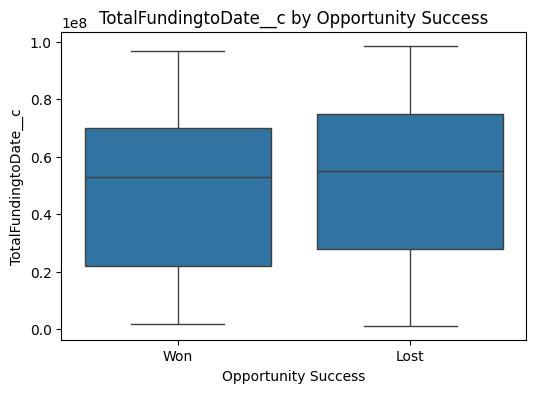

In [11]:
# Boxplot of TotalFundingtoDate__c by Success
#The boxploT result indicates that the a priori money in founding the company is not related to the possibility of it being a good or bad investment.

plt.figure(figsize=(6, 4))
sns.boxplot(x='Success', y='TotalFundingtoDate__c', data=all_accounts)
plt.title('TotalFundingtoDate__c by Opportunity Success')
plt.xlabel('Opportunity Success')
plt.ylabel('TotalFundingtoDate__c')
plt.show()


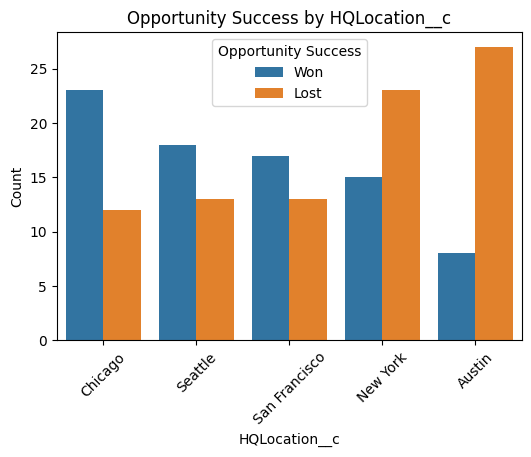

In [12]:
# Opportunity Count by HQLocation__c and Success
location_won_counts = all_accounts[all_accounts['Success'] == 'Won']['HQLocation__c'].value_counts()
ordered_locations = location_won_counts.index
all_accounts['HQLocation__c'] = pd.Categorical(all_accounts['HQLocation__c'], categories=ordered_locations, ordered=True)

# Plot ordenado
plt.figure(figsize=(6, 4))
sns.countplot(x='HQLocation__c', hue='Success', data=all_accounts, order=ordered_locations)
plt.title('Opportunity Success by HQLocation__c')
plt.xlabel('HQLocation__c')
plt.ylabel('Count')
plt.legend(title='Opportunity Success')
plt.xticks(rotation=45)
plt.show()

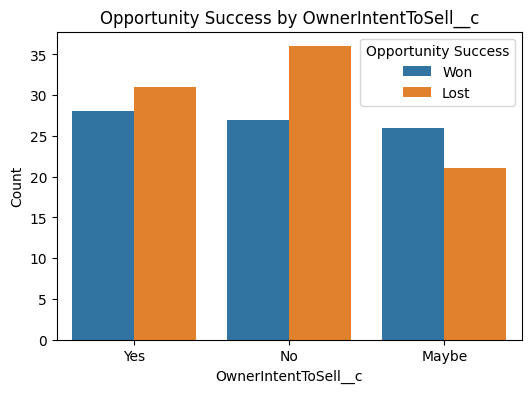

In [13]:
#O gráfico abaixo indica que a intenção de venda por parte do dono não está diretamente relacionada com o sucesso das oportunidades. 
#Isso sugere que a intenção de venda dos donos não é um fator determinante para o sucesso ou fracasso das oportunidades. 
#No entanto, é possível observar que quando os donos têm a intenção de não vender, há uma maior incidência de oportunidades perdidas.



intent_won_counts = all_accounts[all_accounts['Success'] == 'Won']['OwnerIntentToSell__c'].value_counts()
ordered_intents = intent_won_counts.index
all_accounts['OwnerIntentToSell__c'] = pd.Categorical(all_accounts['OwnerIntentToSell__c'], categories=ordered_intents, ordered=True)

# Plot ordenado
plt.figure(figsize=(6,4))
sns.countplot(x='OwnerIntentToSell__c', hue='Success', data=all_accounts, order=ordered_intents)
plt.title('Opportunity Success by OwnerIntentToSell__c')
plt.xlabel('OwnerIntentToSell__c')
plt.ylabel('Count')
plt.legend(title='Opportunity Success')
plt.show()

# Modeling

In [14]:
# Filter only won and lost 
#For the recommendation system, the greatest relevance is how an opportunity will close, whether it will be won or lost.
# Therefore, it is not necessary to add the other StageNames

won_opportunities = opportunity_df[opportunity_df['StageName'] == 'Closed Won']
lost_opportunities = opportunity_df[opportunity_df['StageName'] == 'Closed Lost']


# Merge account data with won and lost opportunities
won_accounts = pd.merge(won_opportunities, account_df, on='AccountId')
lost_accounts = pd.merge(lost_opportunities, account_df, on='AccountId')

# Create Target Column
won_accounts['Success'] = 1
lost_accounts['Success'] = 0
all_accounts = pd.concat([won_accounts, lost_accounts], ignore_index=True)
all_accounts = pd.merge(all_accounts, opportunity_team_member_df, on='OpportunityId', how='left')

# Transform the CreatedDate column to contain only month/year
all_accounts['CreatedDate'] = pd.to_datetime(all_accounts['CreatedDate']).dt.to_period('M')
all_accounts['Role'] = all_accounts['Role'].fillna('MISSING')



In [15]:
all_accounts

,OpportunityId,OpportunityName,AccountId,StageName,Amount,CloseDate,AccountName,OwnerIntentToSell__c,TotalFundingtoDate__c,HQLocation__c,CreatedDate,Success,TeamMemberId,UserId,Role
0,6000000000000,Opportunity 0,1000000000163,Closed Won,240435.52,2024-07-18 00:15:09,Account 163,No,9192093.58,New York,2020-11,1,NaN,NaN,MISSING
1,6000000000001,Opportunity 1,1000000000386,Closed Won,809322.07,2024-01-03 11:48:25,Account 386,Maybe,32303461.65,Seattle,2022-06,1,NaN,NaN,MISSING
2,6000000000003,Opportunity 3,1000000000135,Closed Won,899858.91,2024-02-27 00:28:08,Account 135,Maybe,69995580.53,Chicago,2020-01,1,TM0000000140,5.000000e+09,Manager
3,6000000000003,Opportunity 3,1000000000135,Closed Won,899858.91,2024-02-27 00:28:08,Account 135,Maybe,69995580.53,Chicago,2020-01,1,TM0000000440,5.000000e+09,Manager
4,6000000000015,Opportunity 15,1000000000004,Closed Won,484279.36,2023-06-19 09:02:51,Account 4,Yes,68712413.17,Chicago,2022-11,1,TM0000000429,5.000000e+09,Engineer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,6000000000489,Opportunity 489,1000000000482,Closed Lost,52576.88,2023-07-02 10:28:32,Account 482,No,4251820.35,Chicago,2021-01,0,TM0000000220,5.000000e+09,Sales Rep
222,6000000000489,Opportunity 489,1000000000482,Closed Lost,52576.88,2023-07-02 10:28:32,Account 482,No,4251820.35,Chicago,2021-01,0,TM0000000405,5.000000e+09,Sales Rep
223,6000000000489,Opportunity 489,1000000000482,Closed Lost,52576.88,2023-07-02 10:28:32,Account 482,No,4251820.35,Chicago,2021-01,0,TM0000000474,5.000000e+09,Manager
224,6000000000495,Opportunity 495,1000000000496,Closed Lost,691164.00,2024-07-10 20:04:47,Account 496,No,56173231.52,New York,2022-04,0,NaN,NaN,MISSING


In [16]:
# Select relevant columns for the model

features = ['TotalFundingtoDate__c', 'HQLocation__c', 'OwnerIntentToSell__c', 'Role', 'Amount', 'CreatedDate']
all_accounts = all_accounts[features + ['Success']]

In [17]:
all_accounts

,TotalFundingtoDate__c,HQLocation__c,OwnerIntentToSell__c,Role,Amount,CreatedDate,Success
0,9192093.58,New York,No,MISSING,240435.52,2020-11,1
1,32303461.65,Seattle,Maybe,MISSING,809322.07,2022-06,1
2,69995580.53,Chicago,Maybe,Manager,899858.91,2020-01,1
3,69995580.53,Chicago,Maybe,Manager,899858.91,2020-01,1
4,68712413.17,Chicago,Yes,Engineer,484279.36,2022-11,1
...,...,...,...,...,...,...,...
221,4251820.35,Chicago,No,Sales Rep,52576.88,2021-01,0
222,4251820.35,Chicago,No,Sales Rep,52576.88,2021-01,0
223,4251820.35,Chicago,No,Manager,52576.88,2021-01,0
224,56173231.52,New York,No,MISSING,691164.00,2022-04,0


## Prepare Data for train

In [18]:
# One-hot encoding para variáveis categóricas
all_accounts = pd.get_dummies(all_accounts, columns=['HQLocation__c', 'OwnerIntentToSell__c', 'Role','CreatedDate'], drop_first=True)

# Separar variáveis de entrada e alvo
X = all_accounts.drop('Success', axis=1)
y = all_accounts['Success']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Models for Experiment

In [19]:
#Define different Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

In [20]:
#Evaluate Models

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    results[model_name] = {'Accuracy': accuracy, 'ROC AUC Score': roc_auc}
    print(f"{model_name} - Accuracy: {accuracy}, ROC AUC Score: {roc_auc}")

# Selecionar o melhor modelo com base na ROC AUC Score
best_model_name = max(results, key=lambda k: results[k]['ROC AUC Score'])
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")

Logistic Regression - Accuracy: 0.6521739130434783, ROC AUC Score: 0.5
Random Forest - Accuracy: 0.6739130434782609, ROC AUC Score: 0.6625
Gradient Boosting - Accuracy: 0.6086956521739131, ROC AUC Score: 0.6270833333333333
SVC - Accuracy: 0.5869565217391305, ROC AUC Score: 0.5520833333333334
KNN - Accuracy: 0.5, ROC AUC Score: 0.5291666666666667
Naive Bayes - Accuracy: 0.45652173913043476, ROC AUC Score: 0.4375
Best Model: Random Forest


In [21]:
## Using Classifier as a Recommendation System

In [22]:
def recommend_new_companies(new_data, threshold=0.5):
    new_data = pd.get_dummies(new_data, columns=['HQLocation__c', 'OwnerIntentToSell__c', 'Role'], drop_first=True)
    new_data = new_data.reindex(columns=X.columns, fill_value=0)
    predictions = best_model.predict_proba(new_data)[:, 1]
    new_data['RecommendationScore'] = predictions
    new_data['GoodRecommendation'] = new_data['RecommendationScore'] >= threshold
    return new_data.sort_values(by='RecommendationScore', ascending=False)

num_samples = 1000
new_companies = pd.DataFrame({
    'TotalFundingtoDate__c': np.random.uniform(1e6, 1e8, num_samples),
    'HQLocation__c': np.random.choice(['New York', 'Chicago', 'Seattle', 'San Francisco', 'Austin'], num_samples),
    'OwnerIntentToSell__c': np.random.choice(['Yes', 'No', 'Maybe'], num_samples),
    'Role': np.random.choice(['Sales Rep', 'Manager', 'Engineer', 'Executive Sponsor'], num_samples),
    'Amount': np.random.uniform(1e4, 1e6, num_samples)
})



In [23]:
new_companies

,TotalFundingtoDate__c,HQLocation__c,OwnerIntentToSell__c,Role,Amount
0,8.332777e+07,Chicago,Maybe,Sales Rep,870212.961279
1,4.887365e+07,Seattle,Yes,Executive Sponsor,151660.558123
2,6.339929e+07,San Francisco,Maybe,Sales Rep,294076.104306
3,1.946152e+06,San Francisco,Yes,Engineer,483017.161653
4,5.303204e+07,Seattle,Maybe,Manager,423051.612195
...,...,...,...,...,...
995,4.162179e+07,Austin,Yes,Manager,65089.742532
996,1.881234e+07,San Francisco,Maybe,Manager,926309.775561
997,9.279976e+06,New York,Yes,Sales Rep,735395.323484
998,5.349430e+07,Seattle,No,Sales Rep,171325.334336


In [24]:
recommended_companies = recommend_new_companies(new_companies)

In [25]:
recommended_companies['GoodRecommendation'].value_counts()

GoodRecommendation
True     630
False    370
Name: count, dtype: int64

In [26]:
new_companies.rename(columns={
    'TotalFundingtoDate__c': 'TotalFundingtoDate__c_new',
    'Amount': 'Amount_new'
}, inplace=True)
new_companies = new_companies.join(recommended_companies[['RecommendationScore','GoodRecommendation']])

In [27]:
new_companies

,TotalFundingtoDate__c_new,HQLocation__c,OwnerIntentToSell__c,Role,Amount_new,RecommendationScore,GoodRecommendation
0,8.332777e+07,Chicago,Maybe,Sales Rep,870212.961279,0.67,True
1,4.887365e+07,Seattle,Yes,Executive Sponsor,151660.558123,0.41,False
2,6.339929e+07,San Francisco,Maybe,Sales Rep,294076.104306,0.86,True
3,1.946152e+06,San Francisco,Yes,Engineer,483017.161653,0.73,True
4,5.303204e+07,Seattle,Maybe,Manager,423051.612195,0.64,True
...,...,...,...,...,...,...,...
995,4.162179e+07,Austin,Yes,Manager,65089.742532,0.54,True
996,1.881234e+07,San Francisco,Maybe,Manager,926309.775561,0.46,False
997,9.279976e+06,New York,Yes,Sales Rep,735395.323484,0.52,True
998,5.349430e+07,Seattle,No,Sales Rep,171325.334336,0.55,True


In [28]:
company_names = [f"Company_{i+1}" for i in range(1000)]
new_companies.insert(0, 'CompanyName', company_names)

In [29]:
new_companies

,CompanyName,TotalFundingtoDate__c_new,HQLocation__c,OwnerIntentToSell__c,Role,Amount_new,RecommendationScore,GoodRecommendation
0,Company_1,8.332777e+07,Chicago,Maybe,Sales Rep,870212.961279,0.67,True
1,Company_2,4.887365e+07,Seattle,Yes,Executive Sponsor,151660.558123,0.41,False
2,Company_3,6.339929e+07,San Francisco,Maybe,Sales Rep,294076.104306,0.86,True
3,Company_4,1.946152e+06,San Francisco,Yes,Engineer,483017.161653,0.73,True
4,Company_5,5.303204e+07,Seattle,Maybe,Manager,423051.612195,0.64,True
...,...,...,...,...,...,...,...,...
995,Company_996,4.162179e+07,Austin,Yes,Manager,65089.742532,0.54,True
996,Company_997,1.881234e+07,San Francisco,Maybe,Manager,926309.775561,0.46,False
997,Company_998,9.279976e+06,New York,Yes,Sales Rep,735395.323484,0.52,True
998,Company_999,5.349430e+07,Seattle,No,Sales Rep,171325.334336,0.55,True


In [30]:
new_companies.to_csv('result_recommend_system.csv',sep=",")